# Задачи к Лекции 3

__Исходные данные__ 

Дан файл **"mlbootcamp5_train.csv"**. В нем содержатся данные об опросе 70000 пациентов с целью определения наличия заболеваний сердечно-сосудистой системы (ССЗ). Данные в файле промаркированы и если у человека имееются ССЗ, то значение **cardio** будет равно 1, в противном случае - 0. Описание и значения полей представлены во второй лекции.

__Загрузка файла__

In [21]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

df = pd.read_csv("../data/mlbootcamp5_train.csv", 
                 sep=";", 
                 index_col="id")
df.head()

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
id                                                                          
0   18393       2     168    62.0    110     80            1     1      0   
1   20228       1     156    85.0    140     90            3     1      0   
2   18857       1     165    64.0    130     70            3     1      0   
3   17623       2     169    82.0    150    100            1     1      0   
4   17474       1     156    56.0    100     60            1     1      0   

    alco  active  cardio  
id                        
0      0       1       0  
1      0       1       1  
2      0       0       1  
3      0       1       1  
4      0       0       0

Для начала посмотрим на наши данные.

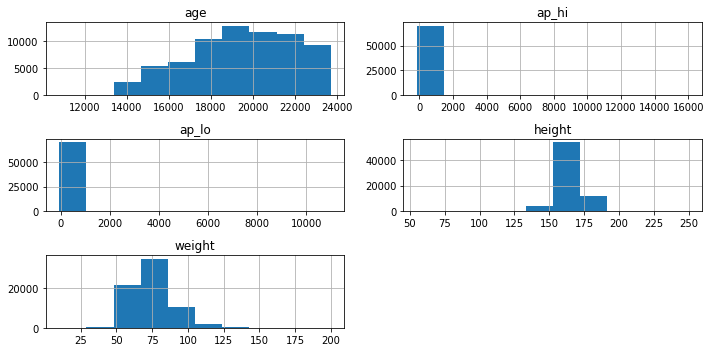

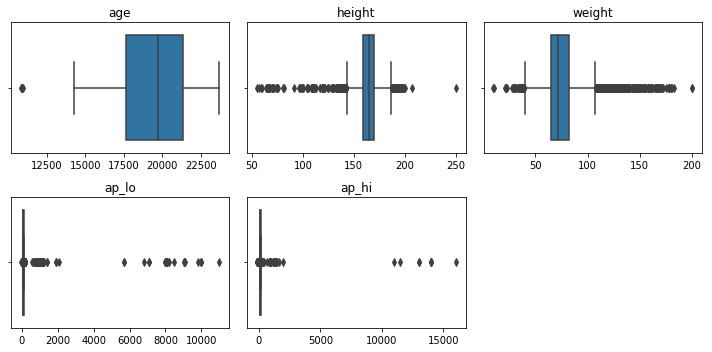

In [176]:
df[["age", "height", "weight", "ap_hi", "ap_lo"]].hist()
plt.tight_layout()
plt.show()

for i, col in enumerate(["age", "height", "weight", "ap_lo", "ap_hi"]):
    plt.subplot(231 + i)
    plt.title(col)
    sns.boxplot(df[[col]])
plt.tight_layout() # это нужно, чтобы графики друг на друга не налезали
plt.show()

Можно увидеть, что для роста, давлений и веса есть выбросы явно указывающие на ошибки в данных, либо на их незначительность и редкость.

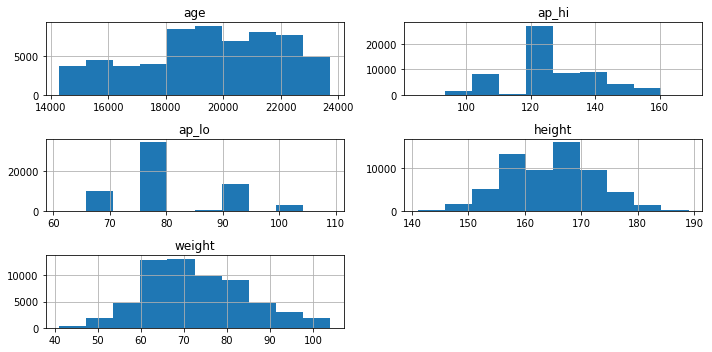

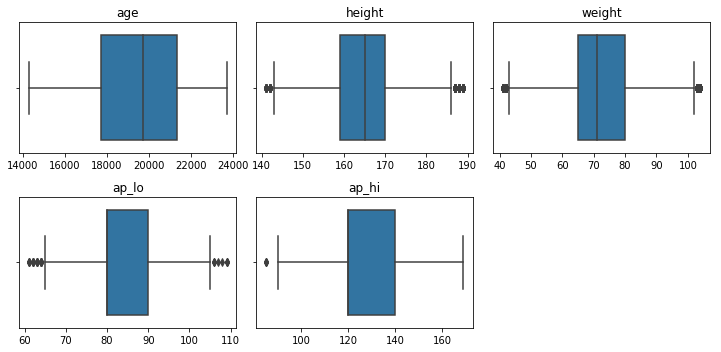

In [48]:
data = df[(df["age"] > 12500)&
          (df["weight"] > 40)&(df["weight"] < 105)&
          (df["height"] > 140)&(df["height"] < 190)&
          (df["ap_lo"] > 60)&(df["ap_lo"] < 110)&
          (df["ap_hi"] > 80)&(df["ap_hi"] < 170)
         ]

data[["age", "height", "weight", "ap_hi", "ap_lo"]].hist()
plt.tight_layout()
plt.show()

for i, col in enumerate(["age", "height", "weight", "ap_lo", "ap_hi"]):
    plt.subplot(231 + i)
    plt.title(col)
    sns.boxplot(data[[col]])
plt.tight_layout() # это нужно, чтобы графики друг на друга не налезали
plt.show()

Таким образом мы убрали некорректные значения и убрали редкие значения.

In [61]:
# чтобы красиво строилась матрица
from sklearn.metrics import confusion_matrix
import itertools

class_names = ["Здоров", "Болен"]
def plot_confusion_matrix(cm, classes, normalize=False, title='Матрица неточностей', cmap=plt.cm.Blues):    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.min() + (cm.max() - cm.min()) * 2 / 3.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Истина')
    plt.xlabel('Предсказание')
    plt.tight_layout()

## Задачи

**1. Построить наивный байесовский классификатор для количественных полей age, height, weight, ap_hi, ap_lo. Исправить данные, если это необходимо. Привести матрицу неточностей и сравнить со значением полученным в ходе лекции. Попытаться объяснить разницу.**

Точность = 0.705188


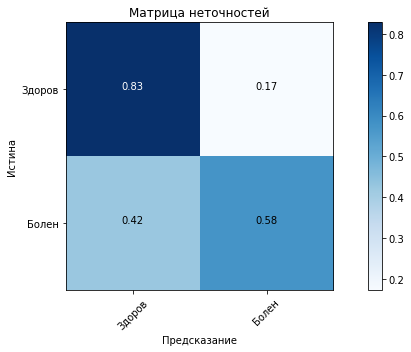

In [143]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

train = data[["age", "height", "weight", "ap_hi", "ap_lo"]]
target = data["cardio"]

gnb = GaussianNB()
model = gnb.fit(train, target)
gprob = gnb.predict_proba(train)
gpred = gnb.predict(train)

acc = accuracy_score(target, gpred) # напоминаю, это просто процент правильно угаданных прецендентов
cnf = confusion_matrix(target, gpred)

print("Точность = %f" % acc)
plot_confusion_matrix(cnf, class_names, normalize=True)

**Комментарии:** Мы видим существенное улучшение с точностью предсказания, по сравнению с тем, что сделано в лекции. Можно предположить, что давление является довольно весомым признаком при определении болен ли человек или нет.

**2. (не обязательно) Придумать как построить наивный байесовский классификатор для категориальных полей cholesterol, gluc. Привести матрицу неточностей и сравнить с предыдущими значениями.**

Основная сложность в том, чтобы понять, как работать с категориальными данными. Здесь мы можем просто вспомнить теорему Байеса и попробовать собрать такой классификатор сами. Давайте сделаем универсальный бинарный классификатор. Для его корректной работы, все категории должны быть переведены в числа (это используется **только** для компактности данных, а не для придания им порядка, значения этих чисел нигде не используются!).

In [148]:
from collections import defaultdict

class CategorialNB:
    """
        Отсносительно универсальный бинарный классификатор по категориальным данным.
        Требует, чтобы категории были заменены на числа. Довольно легко обобщается
        до многоклассового классификатора. Целевой исход должен быть 0 или 1
    """
    def __init__(self):
        self.model = [] # Здесь мы будем хранить вероятности по признакам и классам
        self.weight = [0.5, 0.5] # веса классов (наша априорная вероятность)
        
    def fit(self, data, target):
        # приводим все к типам numpy
        # здесь по идее нужна проверка на то, что данные были правильно представлены,
        # т.е. количество признаков в каждом преценденте одно и то же
        data = np.array(data)
        target = np.array(target)

        if data.shape[0] != target.shape[0]:
            raise Exception("Invalid shapes of data vector and target vector")
            
        if np.logical_not(np.isin(target, [0, 1])).any():
            raise Exception("Invalid target vector")

        self.model = [[{} for _ in range(data.shape[1])] for _ in range(2)]
            
        mask_1 = target == 1
        mask_0 = target == 0                    
            
        # Теперь просто подсчитываем частоты в каждой категории
        for i in range(data.shape[1]):
            cats, counts = np.unique(data[mask_1, i], return_counts=True)
            probs = counts / data.shape[0] # Теперь это вероятность            
            for category, probability in zip(cats, probs):
                self.model[1][i][category] = probability
                
            cats, counts = np.unique(data[mask_0, i], return_counts=True)
            probs = counts / data.shape[0] # Теперь это вероятность            
            for category, probability in zip(cats, probs):
                self.model[0][i][category] = probability
        #print(self.model)
        return self
    
    def predict_proba(self, data):
        data = np.array(data)
        result = np.zeros((data.shape[0], 2))
        result[:, 0] = self.weight[0]
        result[:, 1] = self.weight[1]
        
        for i, row in enumerate(data):
            for j, feature in enumerate(row):
                result[i, 0] = result[i, 0] * self.model[0][j][feature]
                result[i, 1] = result[i, 1] * self.model[1][j][feature]        
        return result / result.sum(axis=1)[:, None]
    
    def predict(self, data):
        proba = self.predict_proba(data)                
        mask = proba[:, 1] > proba[:, 0]
        return mask.astype("int")

Точность = 0.591474


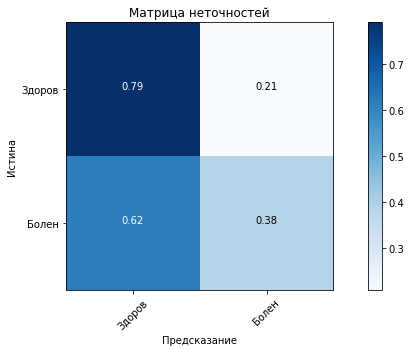

In [149]:
train = data[["cholesterol", "gluc"]]
target = data["cardio"]
cnb = CategorialNB()

cnb.fit(train, target)
cprob = cnb.predict_proba(train)
cpred = cnb.predict(train)

acc = accuracy_score(target, cpred) # напоминаю, это просто процент правильно угаданных прецендентов
cnf = confusion_matrix(target, cpred)

print("Точность = %f" % acc)
plot_confusion_matrix(cnf, class_names, normalize=True)

**Комментарии:** Можно увидеть, что точность сопоставима с признаками, что представлены в лекции. Хотя имеется значительный перекос в сторону ложно-здоровых людей.

Альтернативным вариантом является использование, т.н. One-Hot кодирования. Когда мы создаем множество бинарных признаков, которые фактически отвечают на вопрос "Это значение X?"

In [150]:
# мы может так сделать, т.к. False и True - это фактически 0 и 1
data["gluc_1"] = data["gluc"] == 1 
data["gluc_2"] = data["gluc"] == 2
data["gluc_3"] = data["gluc"] == 3

data["chol_1"] = data["cholesterol"] == 1
data["chol_2"] = data["cholesterol"] == 2
data["chol_3"] = data["cholesterol"] == 3

Точность = 0.591474


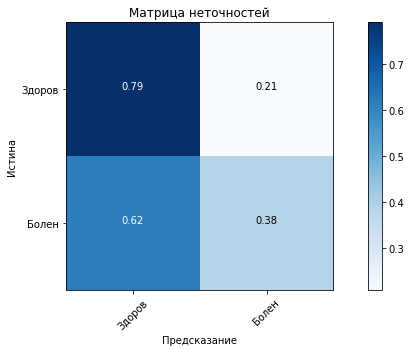

In [153]:
from sklearn.naive_bayes import BernoulliNB

train = data[["gluc_1", "gluc_2", "gluc_3", "chol_1", "chol_2", "chol_3"]]
target = data['cardio']

cbnb = BernoulliNB()
cbnb.fit(train, target)
cbprob = cbnb.predict_proba(train)
cbpred = cbnb.predict(train)

acc = accuracy_score(target, cbpred) # напоминаю, это просто процент правильно угаданных прецендентов
cnf = confusion_matrix(target, cbpred)

print("Точность = %f" % acc)
plot_confusion_matrix(cnf, class_names, normalize=True)

**Комментарии:** Как видно, в данном случае разница не заметна.

**3. Построить наивный байесовский классификатор для бинарных полей gender, smoke, alco, active. Привести матрицу неточностей и сравнить с предыдущими значениями.**

Точность = 0.520472


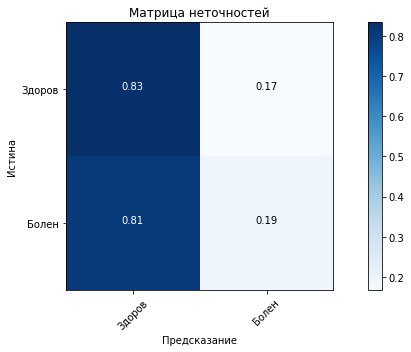

In [154]:
from sklearn.naive_bayes import BernoulliNB

# В начале приводим пол к бинарному признаку
data['gender_b'] = data['gender'].map({1: 0, 2: 1})

train = data[["gender_b", "smoke", "alco", "active"]]
target = data['cardio']

bnb = BernoulliNB()
bnb.fit(train, target)
bprob = bnb.predict_proba(train)
bpred = bnb.predict(train)

acc = accuracy_score(target, bpred) # напоминаю, это просто процент правильно угаданных прецендентов
cnf = confusion_matrix(target, bpred)

print("Точность = %f" % acc)
plot_confusion_matrix(cnf, class_names, normalize=True)

**Комментарии:** В данном случае видно, что точность предсказания на уровне броска монеты. 

**4. К этому моменту у вас есть три независимых классификатора: по количественным полям, категориальным и бинарным. Придумать как их объеденить в один единый классификатор, который учитывает все эти поля. Привести матрицу неточностей для него и сравнить с предыдущими значениями. Попытаться объяснить разницу.**

Самым очевидным подходом является использование таки теоремы Байса

$$
P(болен | \vec{x}) \propto P(болен|\vec{x_1}) P(болен|\vec{x_2}) P(болен|\vec{x_2}) P(болен)
$$

Будем считать, что априорная вероятность того, что человек болен или здоров равна 50%.

Точность = 0.714694


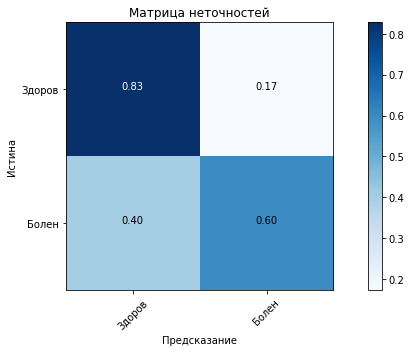

In [169]:
target = data['cardio']
prob = (gprob * cprob * bprob) / (gprob * cprob * bprob).sum(axis=1)[:,None]
predict = (prob[:,1] > prob[:,0]).astype("int")

acc = accuracy_score(target, predict) # напоминаю, это просто процент правильно угаданных прецендентов
cnf = confusion_matrix(target, predict)

print("Точность = %f" % acc)
plot_confusion_matrix(cnf, class_names, normalize=True)

**Комментарии:** Как и следовало ожидать от теоремы Байеса. Наши новые наблюдения увеличивают точность классификатора, хотя и не значительно. По сравнению с классификатором по количественным признакам, мы получили улучшение порядка 1%. При этом процент ложно-здоровых людей уменьшился почти на 2%.

Альтернативным подходом можно считать метод голосования. Если считать, что все классификаторы равноправны, то получим следующее

Точность = 0.622344


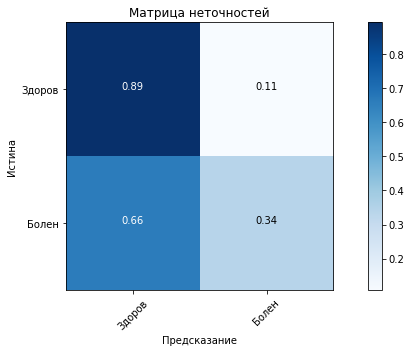

In [175]:
target = data['cardio']
predict = ((gpred + cpred + bpred) > 1.5).astype("int")

acc = accuracy_score(target, predict) # напоминаю, это просто процент правильно угаданных прецендентов
cnf = confusion_matrix(target, predict)

print("Точность = %f" % acc)
plot_confusion_matrix(cnf, class_names, normalize=True)

**Комментарии:** В этом случае мы получили значительно худший результат, т.к. голосование для классификаторов на основе Байеса не самый эффективный подход.